In [92]:
import dask.array as da
import imageio.v3 as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
import os
import pandas as pd
import re
from aicsimageio import AICSImage
from pathlib import Path
from skimage import io, measure, morphology
from skimage.filters import threshold_otsu, threshold_li, threshold_local
from skimage.morphology import white_tophat, disk, square
from skimage import io, img_as_ubyte


# Input and output directories
fl_dir = Path("fl")
labels_dir = Path("largest_label")
output_dir = Path("measurement_output")

if not os.path.exists(output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    
mask_fish = None
image_fl = None
mask_sack_li = None
mask_sack_otsu = None
mask_measure_li = None
mask_measure_otsu = None

rows = []
thrs = []
fracs = []
reg = r'fl.([A-Z,a-z]*)-'
# Process each label image
max_h = 0
max_w = 0
for file_fl in fl_dir.glob("*.tif"):
    image_fl = io.imread(file_fl)
    max_h = max(max_h, image_fl.shape[0])
    max_w = max(max_w, image_fl.shape[1])
print((max_h, max_w))
    

(1329, 1408)


In [90]:
    
# Process each label image
for file_fl in fl_dir.glob("*.tif"):
    
    row = {}
    row['file'] = str(file_fl)
    
    # Load fluorescence image
    #print(str(file_fl))
    image_fl = io.imread(file_fl)
    #image_fl = AICSImage(file_fl).data
    
    result = re.search(reg, str(file_fl))
    row['sample'] = result.groups()[0]
    
    # Load the label image
    file_mask_fish = labels_dir / file_fl.name.replace("fl_max", "tl")
    #print(str(file_mask_fish))
    try:
        mask_fish = io.imread(file_mask_fish)
    except:
        print("labels not found: " + str(file_mask_fish))
        continue
        
    # Apply global thresholding
    li_threshold = threshold_li(image_fl)
    otsu_threshold = threshold_otsu(image_fl)
    mask_sack_li = image_fl > li_threshold
    mask_sack_otsu = image_fl > otsu_threshold
    
    
    try:
        mask_measure_li = ~mask_sack_li & mask_fish
        mask_measure_otsu = ~mask_sack_otsu & mask_fish
    except:
        print('image size mismatch!' + str(file_mask_fish))
        #print()
        continue
        
    row['li'] = li_threshold

    # try different lower thresholds for the non-sack area
    area_max = np.sum(mask_measure_li)
    row['area_max'] = area_max
    
    thrs = [li_threshold / i for i in range(4,9)]
    
    for i in range(len(thrs)):
        #print(i)
        thr = thrs[i]
        img_thr = (image_fl > thr) & mask_measure_li
        area = np.sum(img_thr)
        frac = area / area_max
        row['thr%d'%i] = thr
        row['area%d'%i] = area
        row['area_frac%d'%i] = frac
        
    #print(row)

    # Define a structuring element (e.g., disk-shaped for round features)
    selem = disk(5)

    # Apply the white top-hat filter
    tophat = white_tophat(image_fl, selem)
    thr = threshold_li(tophat) / 2
    tophatli = (tophat > thr) & mask_measure_li
    area_tophatli = np.sum(tophatli)
    row['area_tophatli'] = area_tophatli
    row['area_frac_tophatli'] = area_tophatli / area_max
    

    #row = pd.DataFrame(row)
    rows.append(row)
    
    # Save the new label image
    #io.imsave(os.path.join(output_dir, file), largest_label_image.astype(np.uint16))
    
    #break
df = pd.DataFrame(rows)
df.head()

(1329, 1408)
labels not found: largest_label/control-4-molm-13_s3_tl.tif


/tmp/ipykernel_2055/1629871571.py:98: RuntimeWarning: invalid value encountered in scalar divide
  frac = area / area_max
/tmp/ipykernel_2055/1629871571.py:114: RuntimeWarning: invalid value encountered in scalar divide
  row['area_frac_tophatli'] = area_tophatli / area_max


image size mismatch!largest_label/R-4-molm-13_s3_tl.tif
labels not found: largest_label/control-3-molm-13_s3_tl.tif


,file,sample,li,area_max,thr0,area0,area_frac0,thr1,area1,area_frac1,...,area2,area_frac2,thr3,area3,area_frac3,thr4,area4,area_frac4,area_tophatli,area_frac_tophatli
0,fl/VC-3-molm-13_s3_fl_max.tif,VC,1393.846536,93340,348.461634,19838,0.212535,278.769307,29919,0.320538,...,45994,0.492758,199.120934,54466,0.583523,174.230817,66530,0.712771,794,0.008507
1,fl/S-2-molm-13_s3_fl_max.tif,S,1032.815223,53769,258.203806,49656,0.923506,206.563045,53626,0.997340,...,53769,1.000000,147.545032,53769,1.000000,129.101903,53769,1.000000,3950,0.073462
2,fl/S-1-molm-13_s3_fl_max.tif,S,1570.283513,86777,392.570878,28397,0.327241,314.056703,38349,0.441926,...,47168,0.543554,224.326216,52922,0.609862,196.285439,59545,0.686184,934,0.010763
3,fl/A-3-molm-13_s3_fl_max.tif,A,1400.411798,0,350.102949,0,NaN,280.082360,0,NaN,...,0,NaN,200.058828,0,NaN,175.051475,0,NaN,0,NaN
4,fl/R-3-molm-13_s3_fl_max.tif,R,1646.892359,82096,411.723090,20447,0.249062,329.378472,27229,0.331673,...,34597,0.421421,235.270337,43405,0.528710,205.861545,52748,0.642516,965,0.011755


In [122]:
from dask import delayed
images = []
labels = []

selem = disk(5)

# Process each label image
for file_fl in fl_dir.glob("*.tif"):
    dd = AICSImage(file_fl).get_image_dask_data()
    dd = dd.squeeze()
    
    # how to do this with dask?
    #tophat = delayed(white_tophat)(dd[0,0,0,:,:], selem)
    tophat = delayed(white_tophat)(dd, selem)
    thr_li = delayed(threshold_li)(tophat)
    tophatli = tophat > thr_li

    # Convert to Dask array (if delayed computation was used)
    tophatli_dask = da.from_delayed(tophatli, shape=dd.shape[-2:], dtype=dd.dtype)

    # Expand dimensions to match the original 5D shape
    #tophatli_expanded = da.expand_dims(tophatli_dask, axis=(0, 1, 2))
    #print(tophatli_expanded.shape)

    #print(dd.shape)
    # pad images to same shape for viewing in Napari
    #_,_,_,h,w = dd.shape
    h,w = dd.shape
    #print((h,w))
    #pad_width = ((0,0),(0,0),(0,0),(0,max_h-h),(0,max_w-w))
    pad_width = ((0,max_h-h),(0,max_w-w))
    #print(pad_width)
    dd_pad = da.pad(dd, pad_width)
    #labels_pad = da.pad(tophatli_expanded, pad_width)
    labels_pad = da.pad(tophatli_dask, pad_width)
    print(dd_pad.shape)
    print(labels_pad.shape)
    
    images.append(dd_pad)
    labels.append(labels_pad)


(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)
(1329, 1408)

In [124]:
images_da = da.stack(images)
labels_da = da.stack(labels)
viewer = napari.Viewer()
viewer.add_image(images_da)
viewer.add_image(labels_da)

/tmp/ipykernel_2055/77364146.py:1: PerformanceWarning: Increasing number of chunks by factor of 152
  images_da = da.stack(images)
/tmp/ipykernel_2055/77364146.py:2: PerformanceWarning: Increasing number of chunks by factor of 152
  labels_da = da.stack(labels)


<Image layer 'labels_da' at 0x7aa1bfc08460>

In [79]:
for i in range(len(thrs)):
    fracs.append('area_frac%d'%i)
fracs.append('area_frac_tophatli')

df.groupby(by=['sample'])[fracs].mean()

,area_frac0,area_frac1,area_frac2,area_frac3,area_frac4,area_frac_tophatli
sample,,,,,,
A,0.162702,0.251551,0.361219,0.464383,0.570029,0.008054
C,0.200899,0.305900,0.385452,0.465561,0.539302,0.008901
L,0.704853,0.794348,0.864867,0.926862,0.973567,0.039518
LS,0.552241,0.681827,0.771983,0.847951,0.912613,0.004033
R,0.230691,0.337217,0.430208,0.531381,0.626170,0.014043
RU,0.627202,0.765766,0.853557,0.905625,0.946371,0.065892
S,0.524291,0.635009,0.736568,0.810240,0.876340,0.027926
U,0.296899,0.433991,0.553461,0.688513,0.794103,0.013058
V,0.184408,0.295180,0.405957,0.535609,0.673196,0.009340


## Check how intensities vary between images
As a measure, calculate Otsu and Li thresholds, and the maximum.

Conclusion: they vary quite a bit, so it probably won't be feasible to try to pick one threshold for all.

In [44]:
# Process each fluorescence image
otsu = []
li = []
maxint = []
for file_fl in fl_dir.glob("*.tif"):
    tmp = io.imread(file_fl)
    otsu.append(threshold_otsu(tmp))
    li.append(threshold_li(tmp))
    maxint.append(tmp.max())


(array([ 1.,  3.,  0.,  4.,  3., 11., 11.,  9.,  2.,  3.]),
 array([1195. , 1789.4, 2383.8, 2978.2, 3572.6, 4167. , 4761.4, 5355.8,
        5950.2, 6544.6, 7139. ]),
 <BarContainer object of 10 artists>)

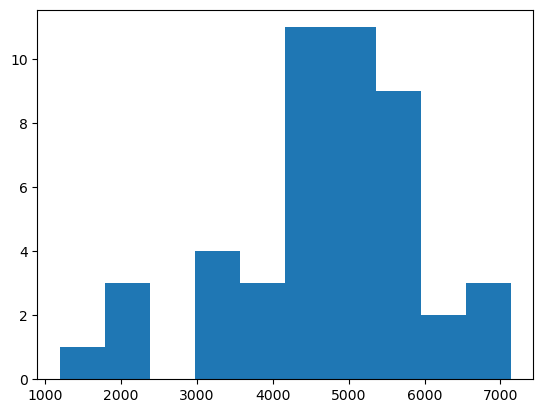

In [45]:
plt.hist(otsu)

(array([ 1.,  0.,  0.,  1.,  4.,  6.,  7., 12.,  8.,  8.]),
 array([  40.70791226,  242.61440469,  444.52089712,  646.42738954,
         848.33388197, 1050.24037439, 1252.14686682, 1454.05335925,
        1655.95985167, 1857.8663441 , 2059.77283653]),
 <BarContainer object of 10 artists>)

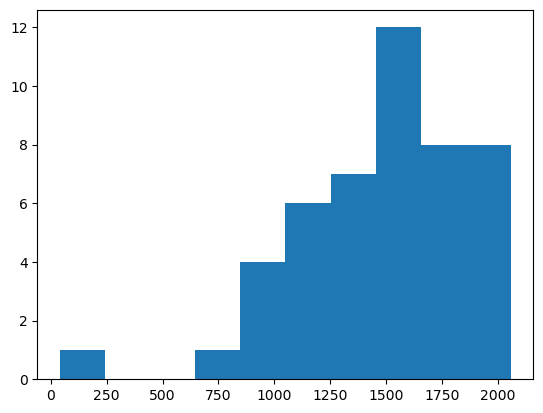

In [46]:
plt.hist(li)

(array([3., 3., 6., 8., 6., 7., 7., 2., 2., 3.]),
 array([16709. , 18301.4, 19893.8, 21486.2, 23078.6, 24671. , 26263.4,
        27855.8, 29448.2, 31040.6, 32633. ]),
 <BarContainer object of 10 artists>)

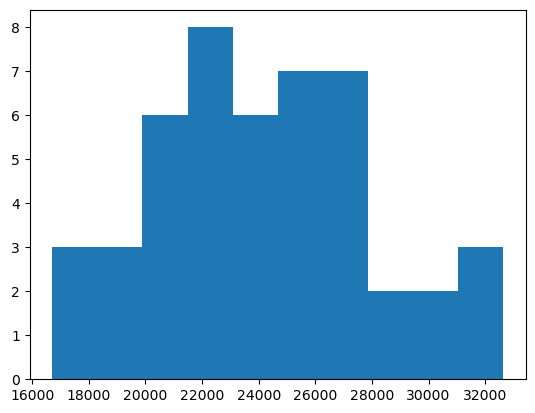

In [47]:
plt.hist(maxint)

In [48]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)
import tifffile
print(tifffile.__version__)
!micromamba list|grep tiff


2.0.1
0.24.0
2024.9.20
  libtiff                    4.5.1         h6a678d5_0                      


In [49]:
print(image_fl.shape)
print(mask_sack_li.shape)

(1108, 949)
(1108, 949)


## Let's say we can use Li threshold to get the egg sack

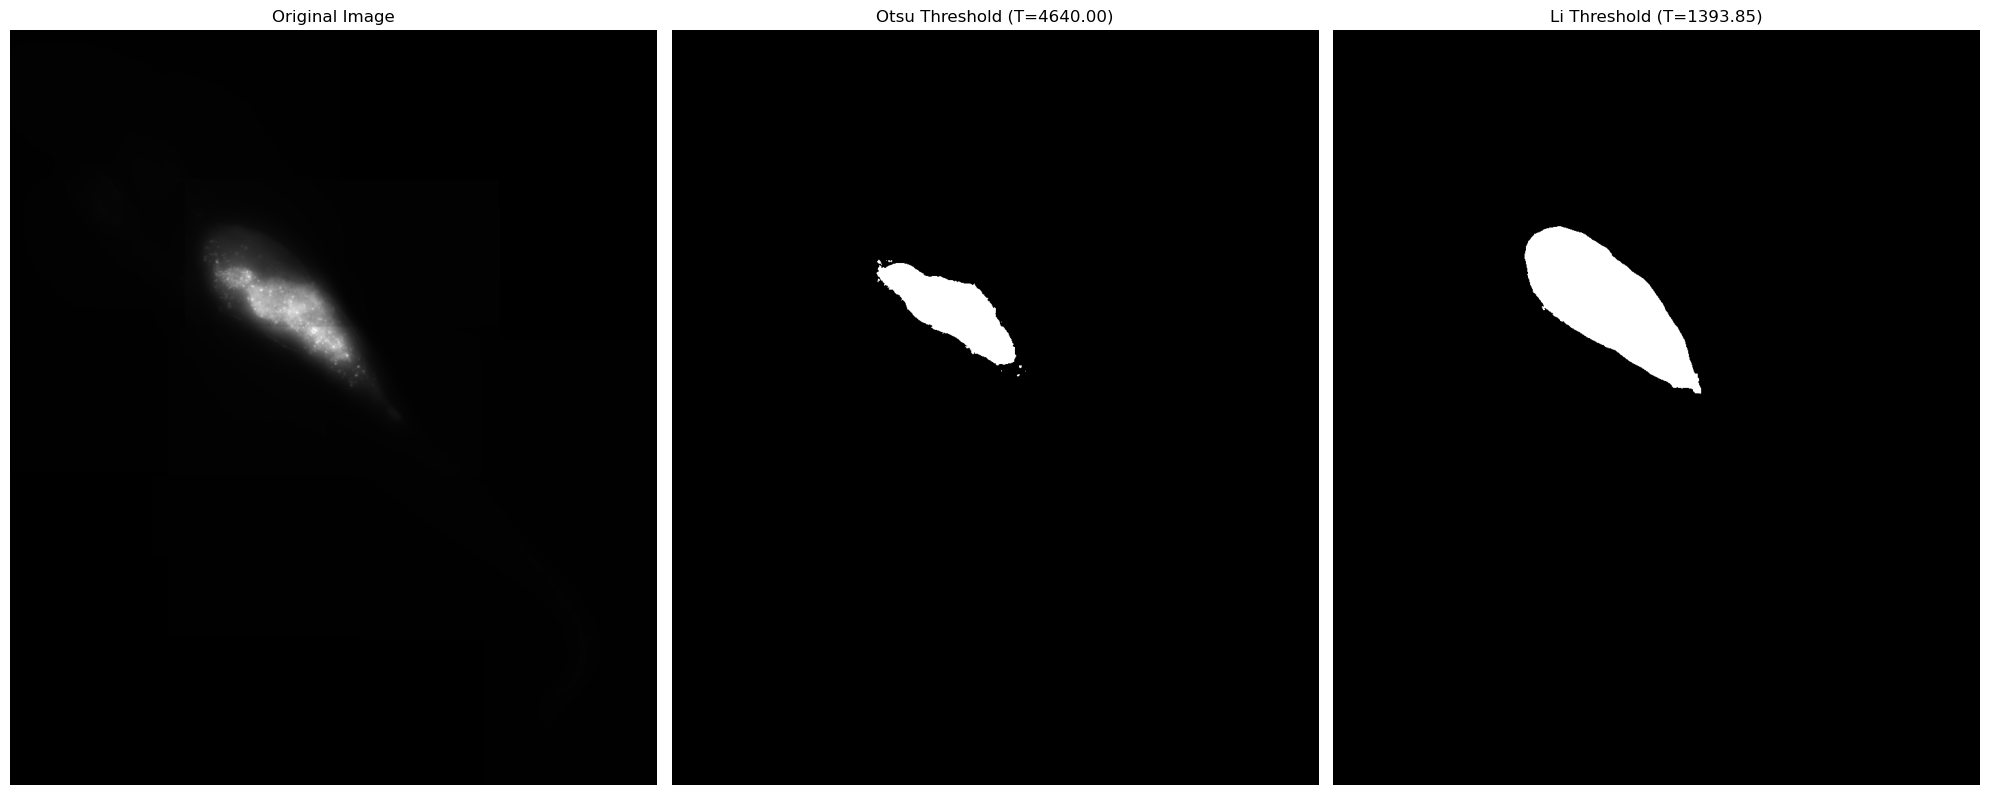

In [50]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 16))
ax = axes.ravel()

ax[0].imshow(image_fl, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[1].imshow(mask_sack_otsu, cmap=plt.cm.gray)
ax[1].set_title(f'Otsu Threshold (T={otsu_threshold:.2f})')
ax[2].imshow(mask_sack_li, cmap=plt.cm.gray)
ax[2].set_title(f'Li Threshold (T={li_threshold:.2f})')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

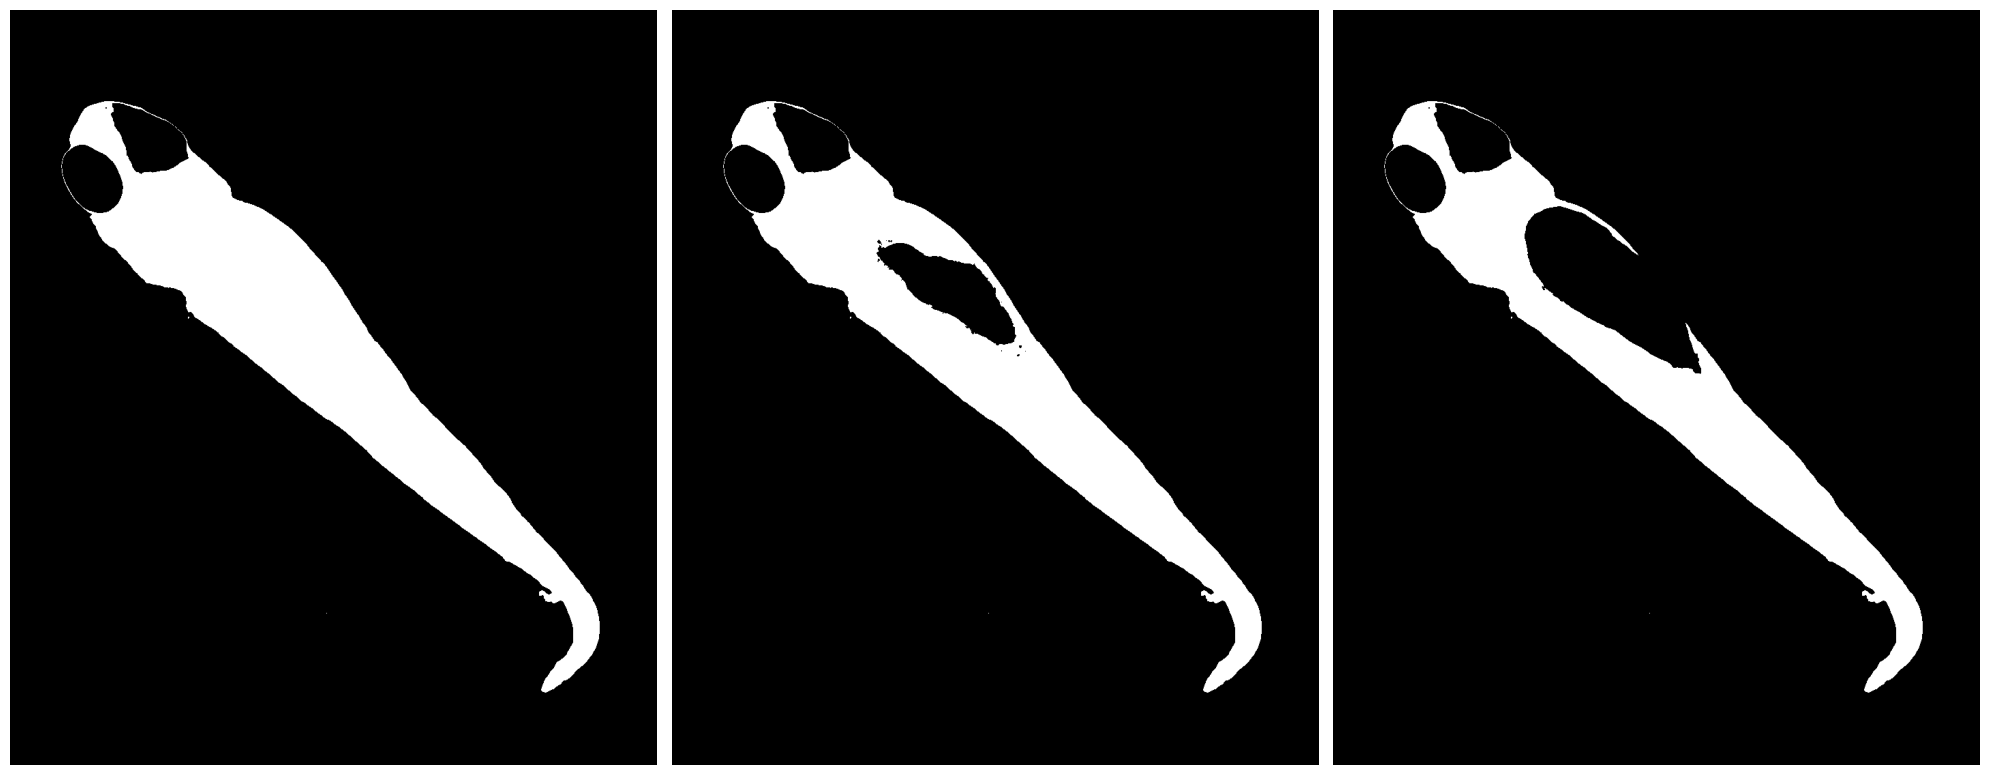

In [51]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 16))
ax = axes.ravel()

ax[0].imshow(mask_fish, cmap=plt.cm.gray)
ax[1].imshow(mask_measure_otsu, cmap=plt.cm.gray)
ax[2].imshow(mask_measure_li, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [52]:
mask_fish.max()

np.uint16(1)

In [53]:
mask_sack_li.max()

np.True_

## How about adding a filter to the mix?

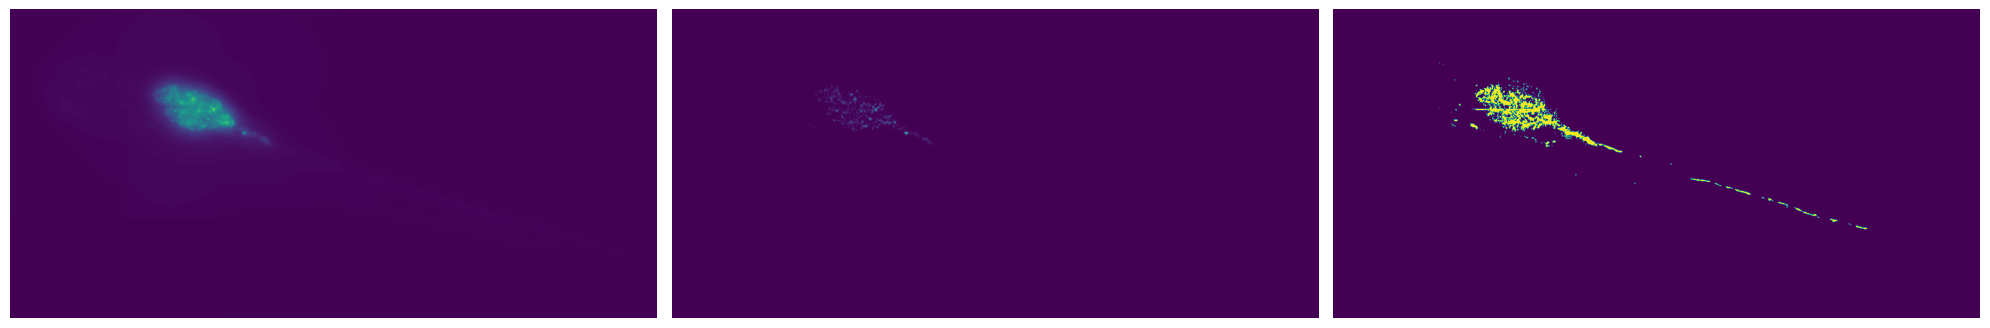

In [80]:
from skimage.morphology import white_tophat, disk, square
from skimage import io, img_as_ubyte


# Define a structuring element (e.g., disk-shaped for round features)
selem = disk(5)
#selem = square(5)

# Apply the white top-hat filter
tophat = white_tophat(image_fl, selem)
tophatli = tophat > (threshold_li(tophat) / 2)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 16))
ax = axes.ravel()

ax[0].imshow(image_fl)#, cmap=plt.cm.gray)
ax[1].imshow(tophat)#, cmap=plt.cm.gray)
ax[2].imshow(tophatli)#, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

## But how to pick threshold for the rest of the fish?
This is what Elham was asking since the beginning. I don't have an answer really.

In [56]:
# Let's just divide the Li threshold to get some numbers
thrs = [li_threshold / i for i in range(4,12)]
#thrs = [ i for i in range(6,14)]
thrs

[np.float64(348.46163400851435),
 np.float64(278.7693072068115),
 np.float64(232.30775600567623),
 np.float64(199.12093371915105),
 np.float64(174.23081700425718),
 np.float64(154.87183733711748),
 np.float64(139.38465360340575),
 np.float64(126.71332145764158)]

19838
1
19838.0
0.21253481894150417
29919
1
29919.0
0.32053781872723375
45994
1
45994.0
0.4927576601671309
54466
1
54466.0
0.5835226055281766
66530
1
66530.0
0.7127705163916863
77501
1
77501.0
0.8303085493893293
87492
1
87492.0
0.9373473323334047
92801
1
92801.0
0.9942254124705379


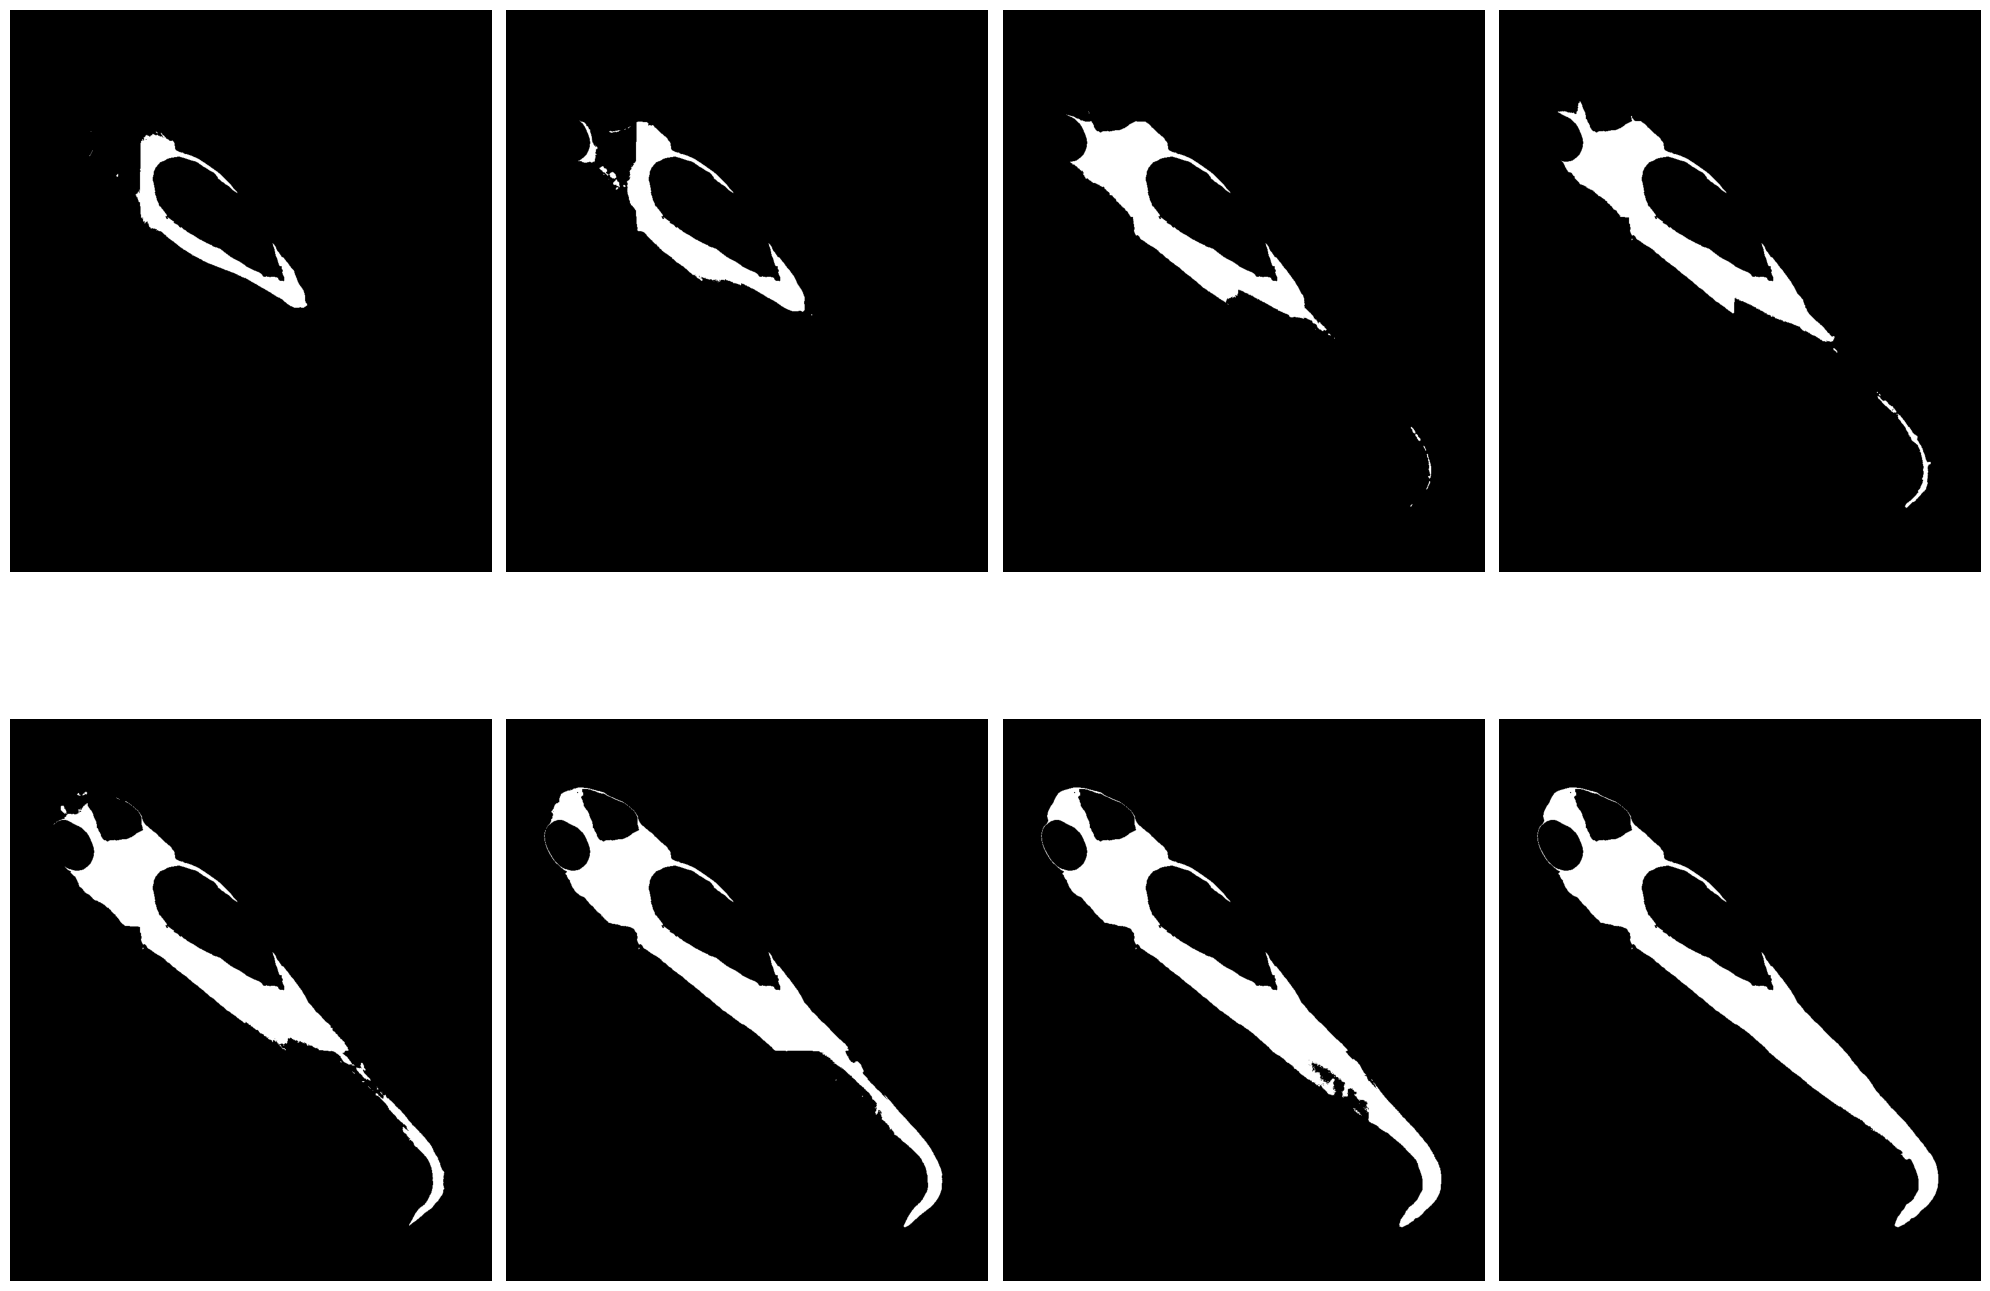

In [57]:
# Plot results
fig, axes = plt.subplots(2, 4, figsize=(20, 16))
ax = axes.ravel()

i = 0
area_max = np.sum(mask_measure_li)
for thr in thrs:
    img_thr = (image_fl > thr) & mask_measure_li
    area = np.sum(img_thr) 
    print(area)
    
    # another way to get area
    properties = measure.regionprops(img_thr)
    print(len(properties))
    print(properties[0].area)
    
    print(area/area_max)
    ax[i].imshow(img_thr, cmap=plt.cm.gray)
    i = i+1

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# 